In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
from imutils import paths
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
import os
import tensorflow as tf
from keras.layers import Input

import os
file_list=[]
file_list.append(os.listdir(r"/content/drive/MyDrive/Machine/real_and_fake_face/real"))
file_list.append(os.listdir(r"/content/drive/MyDrive/Machine/real_and_fake_face/fake"))


# general path
path='/content/drive/MyDrive/Machine/real_and_fake_face/'

W=224
H=224

# list of classes
class_names=['real', 'fake']

X = []
y = []

# Feature extraction
for classes_files, classe in zip (file_list, range(2)):
    for i in range(950):
      name= str(path) + str(class_names[classe]) + str('/') + str(classes_files[i])
      print(name)
      imagem = cv2.imread(name)
      imagem = cv2.resize(imagem,(W,H))  #### <=====
      xd = image.img_to_array(imagem)
      X.append(xd)
      y.append(classe)

# salvando a imagens lidas
np.save('X.npy', X)

# Saving the classes in a csv file
df_class = pd.DataFrame(y)
df_class.to_csv('y.csv', header=False, index=False)

/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00090.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00077.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00027.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00039.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00100.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00044.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00123.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00152.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00032.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00144.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00034.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00103.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00141.jpg
/content/drive/MyDrive/Machine/real_and_fake_face/real/real_00118.jpg
/content/drive/MyDri

In [ ]:
# Rótulos
from tensorflow.keras.utils import to_categorical

y = pd.read_csv('y.csv', header=None)
y=y.to_numpy()
y=np.ravel(y)
y = to_categorical(y)
print(y.shape)

# Imagens
X = np.load('X.npy')
print(X.shape)

(1900, 2)
(1900, 224, 224, 3)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling2D
from keras.applications.vgg16 import VGG16

vgg_16 = VGG16(weights='imagenet', include_top=False, input_shape=(W, H, 3))
vgg_16.trainable=False
vgg_16.summary()

# Fine Tunning
model = Sequential()
model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'] )

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Ajuste fino com aumento de dados (Data Augmentation)

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# ModelCheckPoint
fp='./bestmodel.hdf5'
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=fp,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

# Inicialização do gerador de imagens - aplica aleatoriamente distorções
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.15,
        width_shift_range=0.1,
        height_shift_range=0.1)

# Holdout 80/20 (80% para treinar e 20% para testar)
trainX, testX, trainY, testY = train_test_split(X, y, test_size=.2,random_state=42,stratify=y)

# Separando da base de treinamento 20% para validação
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=.2,random_state=42,stratify=trainY)

# Gerador de lote de imagens aplicando o ImageDataGenerator
train_generator = datagen.flow(trainX, trainY, batch_size=32)

print(trainX.shape)
print(testX.shape)
print(valX.shape)
# Treinamento considerando o gerador de iamgens de treino
results = model.fit(train_generator, validation_data=(valX, valY), epochs=50, verbose=1, callbacks=[mc])

# Os pesos do melhor modelo são carregados
model.load_weights(fp)

(1216, 224, 224, 3)
(380, 224, 224, 3)
(304, 224, 224, 3)
Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 21.7457 - accuracy: 0.5173
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./bestmodel.hdf5
38/38 [==============================] - 35s 567ms/step - loss: 21.7457 - accuracy: 0.5173 - val_loss: 1.2249 - val_accuracy: 0.5000
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 1.6433 - accuracy: 0.5781
Epoch 2: val_accuracy improved from 0.50000 to 0.58882, saving model to ./bestmodel.hdf5
38/38 [==============================] - 20s 528ms/step - loss: 1.6433 - accuracy: 0.5781 - val_loss: 0.9481 - val_accuracy: 0.5888
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.6406
Epoch 3: val_accuracy improved from 0.58882 to 0.61513, saving model to ./bestmodel.hdf5
38/38 [==============================] - 19s 510ms/step - loss: 0.8743 - accuracy: 0.6406 - val_loss: 0.8722 - val_accuracy: 0.615

In [ ]:
# Avaliando o modelo na base de teste
_, acc = model.evaluate(testX, testY, verbose=0)
print('Final Accuracy: > %.3f' % (acc * 100.0))


Final Accuracy: > 61.316


12/12 [==============================] - 2s 143ms/step
Confusion matrix, without normalization
[[138  52]
 [ 95  95]]


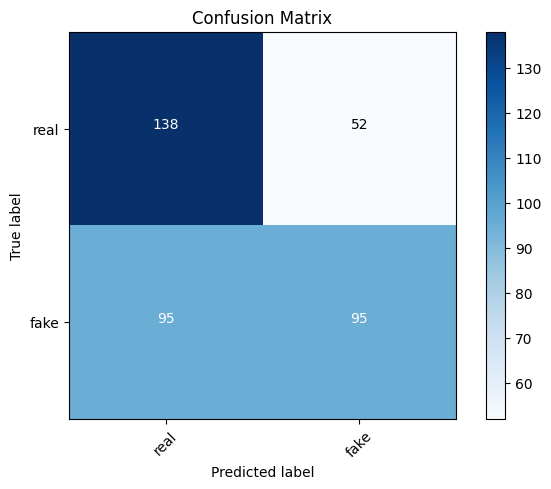

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style as sty

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

import os
import random as rn
import seaborn as sns

import tensorflow as tf
import cv2

# Plotar a matrix de confusão
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)

  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

# Predição da CNN
y_predict=np.argmax(model.predict(testX), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(np.argmax(testY, axis=1), y_predict)

cm_plot_labels=class_names
plot_confusion_matrix(cm, cm_plot_labels, title= 'Confusion Matrix')